# CSC413: Final Project

In [48]:
import numpy as np
import math
import torch
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from livelossplot import PlotLosses
import matplotlib

import importlib
import dynaopt
importlib.reload(dynaopt)
from dynaopt import DynamicOptimizer

%matplotlib inline

## Convolutional Neural Network

The dataloading and model framework are adapted from [CSC413: Tutorial 4](https://colab.research.google.com/github/uoft-csc413/2023/blob/master/assets/tutorials/tut04_cnn.ipynb#scrollTo=Ztj0yQO8-TtS).

### Load the data

In [2]:
np.random.seed(413)

batch_size = 500
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

# Prepare train and val sets
train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
valid_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_size = len(train_set)

valid_prop = 0.2
indices = list(range(train_size))
split = int(np.floor(valid_prop * train_size))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare test set
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

# Prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_idx), sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)

data_loaders = {"train": train_loader, "test": test_loader, "val": valid_loader}
dataset_sizes = {"train": len(train_idx), "test": test_size, "val": len(valid_idx)}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    print("Using GPUs")
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    # for mac
    print("Using GPUs (mac)")
    device = torch.device('mps')
else:
    device = torch.device("cpu")

Using GPUs (mac)


In [4]:
val_inputs, val_labels = next(iter(valid_loader))
print(val_inputs.shape, val_labels.shape)

val_inputs = val_inputs.to(device)
val_labels = val_labels.to(device)

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


### Define the model

In [5]:
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)
    
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 32) # in_channels, out_channels, kernel_size
        self.pool1 = torch.nn.MaxPool2d(1)      # kernel_size
        self.conv2 = torch.nn.Conv2d(16, 32, 1)
        self.pool2 = torch.nn.MaxPool2d(1)
        self.fc1 = torch.nn.Linear(32, 128)     # in_features, out_features
        self.fc2 = torch.nn.Linear(128, 10)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        # print("After conv1: {}".format(x.shape))
        x = self.pool1(x)
        # print("After pool1: {}".format(x.shape))
        x = self.conv2(x)
        # print("After conv2: {}".format(x.shape))
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [6]:
model = ConvNet()
model.to(device)

model2 = ConvNet()
model2.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(32, 32), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

### Define the loss & optimizer

In [8]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = DynamicOptimizer(model.parameters(), lr=0.001, debug=True)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001)

In [49]:
optimizer = DynamicOptimizer(model.parameters(), lr=0.001, lr_choices=[], debug=True)

### Train

In [50]:
def train(model, optimizer, epochs):
    np.random.seed(413)

    liveloss = PlotLosses()
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs - 1))
        print("-" * 30)
        
        epoch_loss = {"train": 0.0, "test": 0.0}
        epoch_acc = {"train": 0.0, "test": 0.0}
        
        running_loss = {"train": 0.0, "test": 0.0}
        running_corrects = {"train": 0, "test": 0}
        
        for phase in ["train", "test"]:
            if phase == "train":
                model.train(True)
            else:
                model.train(False)
            
            for data in data_loaders[phase]:
                inputs, labels = data
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if torch.is_grad_enabled():
                    optimizer.zero_grad() # clear all gradients
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = loss_fn(outputs, labels)

                if phase == "train":
                    if loss.requires_grad:
                        # calculate loss gradient
                        loss.backward()
                    if 'DynamicOptimizer' in str(optimizer):
                        # define closure
                        def closure():
                            # calculate loss based on val set
                            outputs_val = model(val_inputs)
                            loss_val = loss_fn(outputs_val, val_labels)
                            return loss_val
                        optimizer.step(closure) # update weights/biases using best lr
                    else:
                        # update as per optimizer rule
                        optimizer.step()
                
                running_loss[phase] += loss.data.item() * inputs.size(0)
                running_corrects[phase] += torch.sum(preds == labels.data).item()
            
            epoch_loss[phase] = running_loss[phase] / dataset_sizes[phase]
            epoch_acc[phase] =  running_corrects[phase] / dataset_sizes[phase]

        # Visualize the loss and accuracy values.
        liveloss.update({
            'train_loss': epoch_loss["train"],
            'test_loss': epoch_loss["test"],
            'train_acc': epoch_acc["train"],
            'test_acc': epoch_acc["test"],
        })
        liveloss.draw() 

    #40 ish works

### Checking

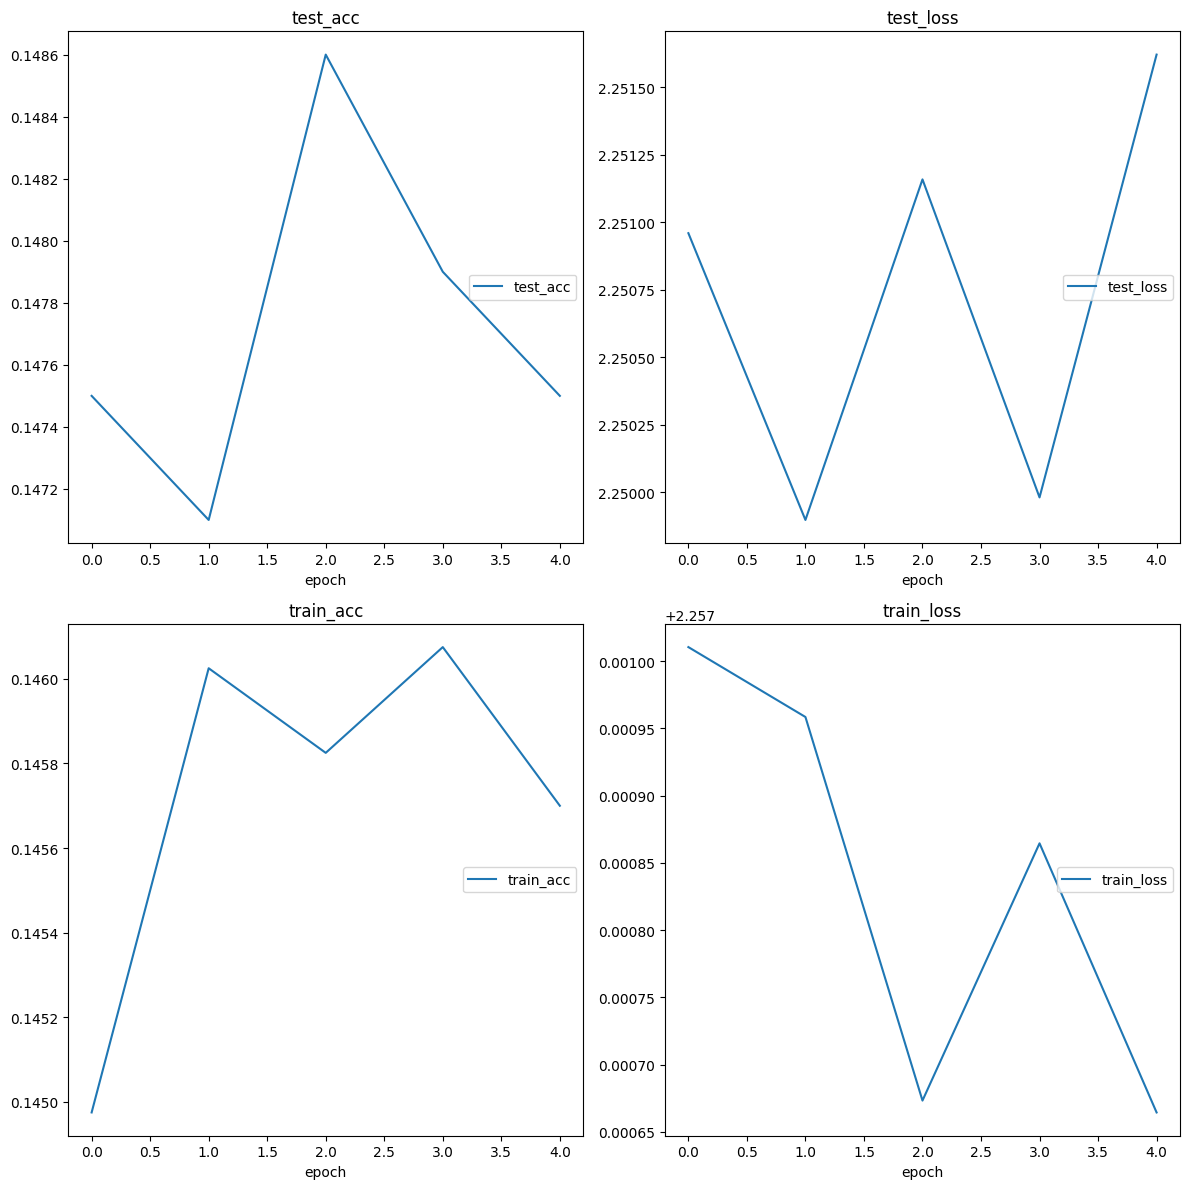

test_acc
	test_acc         	 (min:    0.147, max:    0.149, cur:    0.147)
test_loss
	test_loss        	 (min:    2.250, max:    2.252, cur:    2.252)
train_acc
	train_acc        	 (min:    0.145, max:    0.146, cur:    0.146)
train_loss
	train_loss       	 (min:    2.258, max:    2.258, cur:    2.258)


In [54]:
train(model, optimizer, epochs=5)

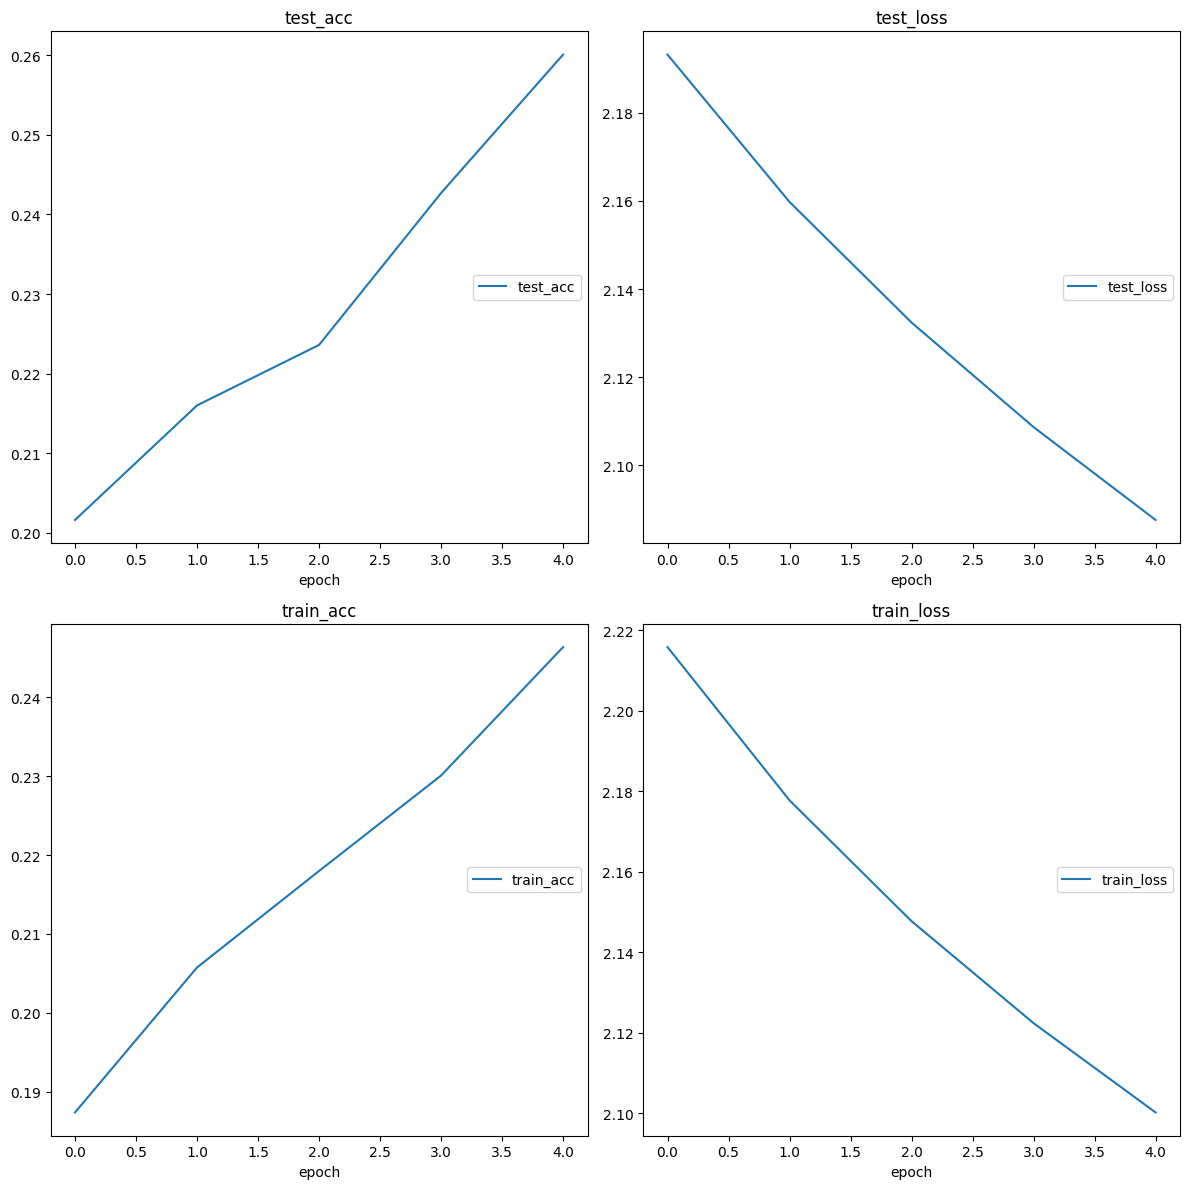

test_acc
	test_acc         	 (min:    0.202, max:    0.260, cur:    0.260)
test_loss
	test_loss        	 (min:    2.088, max:    2.193, cur:    2.088)
train_acc
	train_acc        	 (min:    0.187, max:    0.246, cur:    0.246)
train_loss
	train_loss       	 (min:    2.100, max:    2.216, cur:    2.100)


In [53]:
train(model2, optimizer2, epochs=5)

### Results

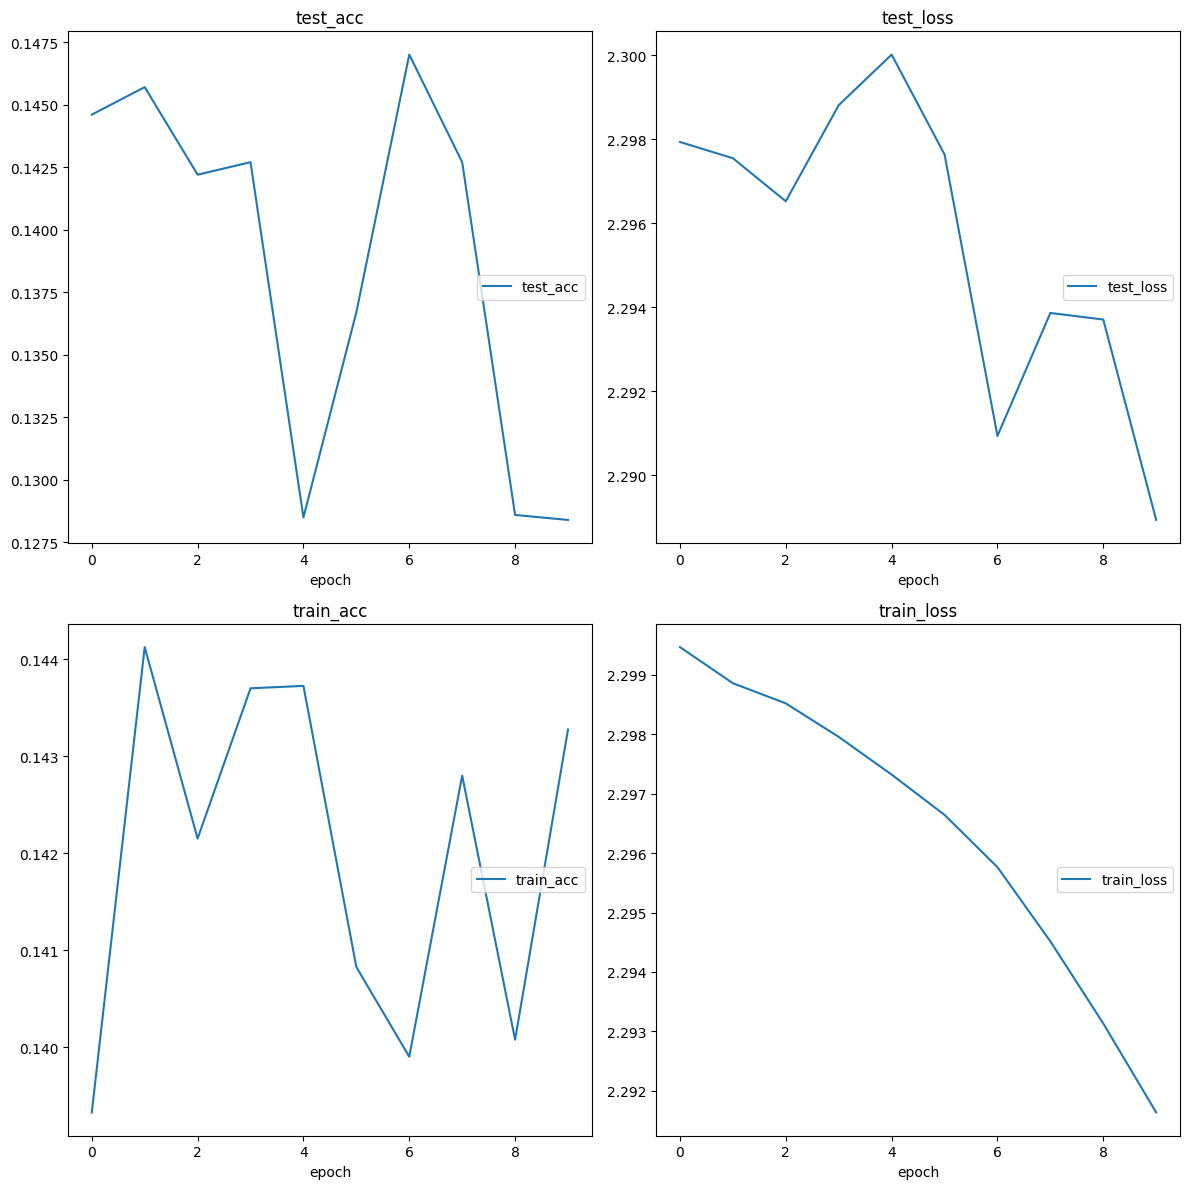

test_acc
	test_acc         	 (min:    0.128, max:    0.147, cur:    0.128)
test_loss
	test_loss        	 (min:    2.289, max:    2.300, cur:    2.289)
train_acc
	train_acc        	 (min:    0.139, max:    0.144, cur:    0.143)
train_loss
	train_loss       	 (min:    2.292, max:    2.299, cur:    2.292)


In [155]:
train(model, optimizer, epochs=10)

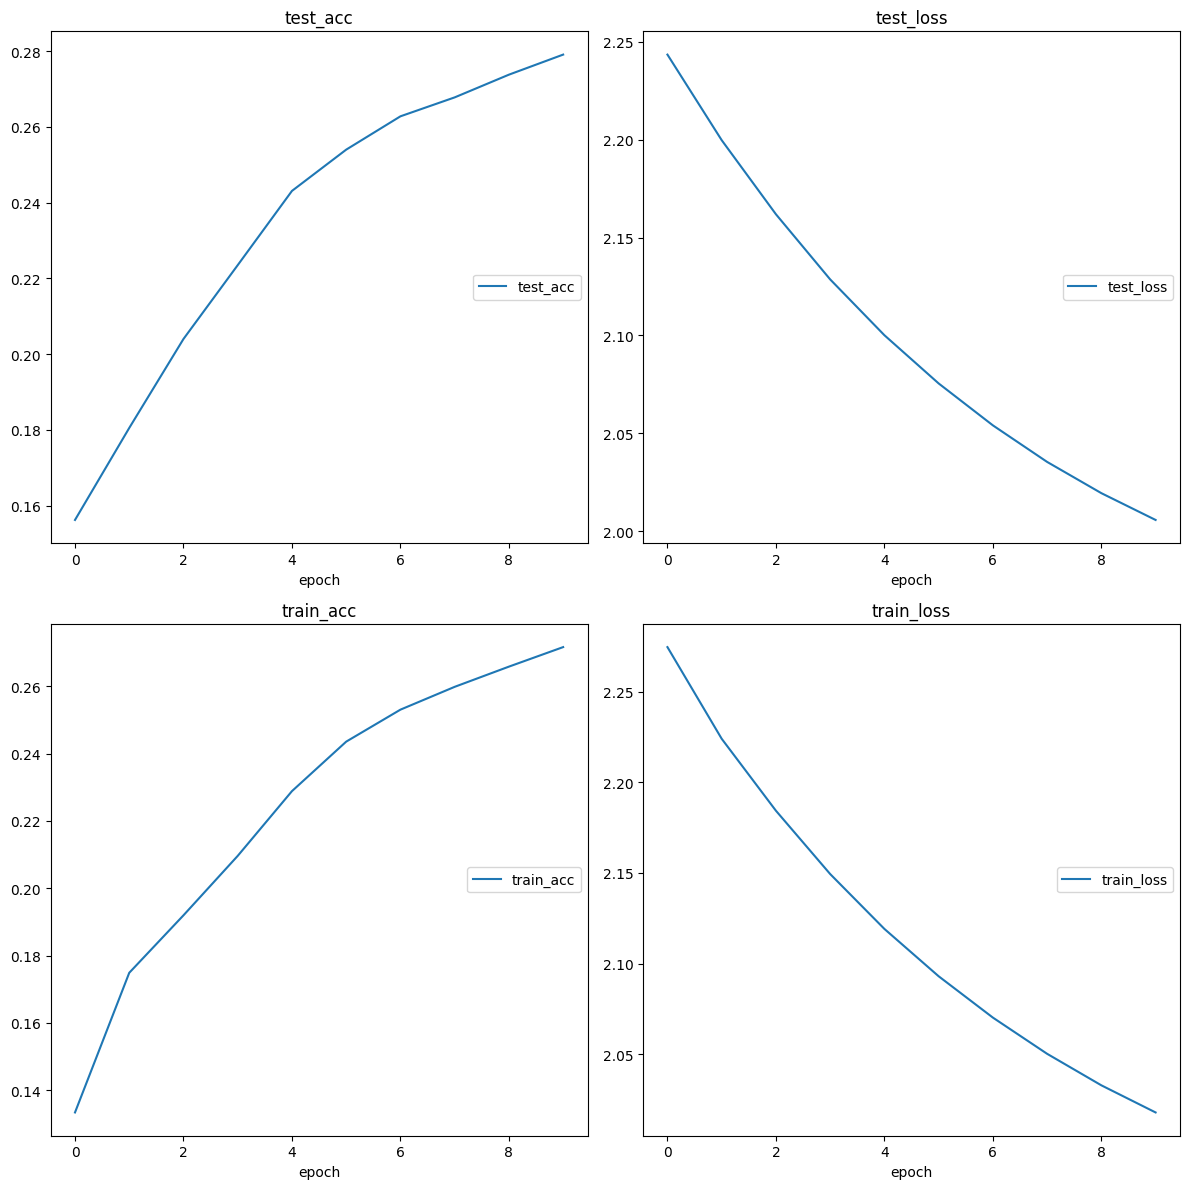

test_acc
	test_acc         	 (min:    0.156, max:    0.279, cur:    0.279)
test_loss
	test_loss        	 (min:    2.006, max:    2.243, cur:    2.006)
train_acc
	train_acc        	 (min:    0.133, max:    0.272, cur:    0.272)
train_loss
	train_loss       	 (min:    2.018, max:    2.275, cur:    2.018)


In [156]:
# Compare with SGD
train(model2, optimizer2, epochs=10)